### Measuring and characterizing fairness as a notion of inclusiveness.

Certain Machine Learning models are made to perform classification tasks of samples over labels which are subjective, what means that several users of the models might judge the label of the sample differently depending on their personal experience.

The predictions of the models might contain biases towards certain types of judgements which are more common than others and consequently easier to learn, and ignore other judgements. These biases might already be contained in the training dataset or generated by the classification model. 

However for the predictions to be fair towards each user of the model, they should be inclusive of all the different judgements, and possibly should be tuned to each of the users.

In this tutorial we teach:
- how to use metrics to measure how fair according to this notion of inclusiveness the models are,
- and how to use various characterizations of the predictions to understand where the unfairness might come from.

The tutorial is based on the example use-case of a Machine Learning model to classify the toxicity of a sentence (see image below).
We train a classifier (Logistic Regression) using the toxicity dataset (sentences and toxicity labels) to predict sentence toxicity, and evaluate how fair the outputs of the process are based on the ground truth annotations provided by multiple judges (crowdsourcing annotators).

![title](images/overview_tutorial_fairness_inclusiveness.png)

# Import statements

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")  

#from aif360.datasets import GermanDataset
from aif360.datasets import ToxicityDataset
from aif360.metrics import InclusivenessLabelDatasetMetric

from IPython.display import Markdown, display


from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import sklearn.metrics as sk_met
from sklearn.base import TransformerMixin, BaseEstimator

import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

## Load the toxicity dataset

In [2]:
### The toxicity dataset (toxicity_annotations.tsv, toxicity_annotated_comments.tsv, toxicity_worker_demographics.tsv) should be downloaded from https://figshare.com/articles/Wikipedia_Talk_Labels_Toxicity/4563973
### and placed in the folder "data/raw/toxicity".

tox_dataset = ToxicityDataset()

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
### For now we do not use the whole dataset to be faster
n_lim = 500000
tox_dataset.dataset = tox_dataset.dataset[:n_lim]
dataset_orig_train, dataset_orig_test = tox_dataset.split([0.7], shuffle=True)

In [4]:
# Check the dataset
dataset_orig_train.dataset.head()

,index,rev_id,worker_id,label,label_score,gender,english_first_language,age_group,education,pop_label,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
212203,257570,77703622.0,218,0,1.0,female,0.0,45-60,masters,female 45-60 masters,train,0.9,0,0.089130,0.9,would thought important information event next...
227749,276480,83660958.0,2452,0,0.0,male,0.0,18-30,professional,male 18-30 professional,train,0.7,0,0.104895,0.7,vandalise vandalise wrong insulting accuse som...
354333,430124,137931502.0,2986,1,-2.0,male,0.0,18-30,bachelors,male 18-30 bachelors,train,0.8,1,0.075724,0.8,nair sorry karl able see mason article time cu...
292376,354902,110077873.0,4224,0,0.0,female,0.0,30-45,bachelors,female 30-45 bachelors,train,1.0,0,0.011494,1.0,wrong care opus dei stuff care long presented ...
323364,392596,123459055.0,1513,0,1.0,female,0.0,18-30,bachelors,female 18-30 bachelors,train,0.9,0,0.042453,0.9,cannot exclude info long reputable sources cal...


## Train a model with the loaded data

In [5]:
### Clean useless information
def prepare_aggregated_data(comment_):
    # Get the unique comments
    comments = comment_.dataset.drop_duplicates('rev_id')
    # Cleaning
    comments = comments.drop('index', 1)
    comments = comments.drop('label', 1)
    comments = comments.drop('label_score', 1)
    comments = comments.drop('worker_id', 1)
    comments = comments.drop('gender', 1)
    comments = comments.drop('age_group', 1)
    comments = comments.drop('education', 1)
    comments = comments.drop('pop_label', 1)
    comments = comments.drop('english_first_language', 1)
    return comments

In [6]:
dataset_train_comments = prepare_aggregated_data(dataset_orig_train)
dataset_test_comments = prepare_aggregated_data(dataset_orig_test)

In [7]:
dataset_train_comments.head()

,rev_id,general_split,sample_agreement,MV,annotator_ADR,popularity_percentage,comment
212203,77703622.0,train,0.9,0,0.089130,0.9,would thought important information event next...
227749,83660958.0,train,0.7,0,0.104895,0.7,vandalise vandalise wrong insulting accuse som...
354333,137931502.0,train,0.8,1,0.075724,0.8,nair sorry karl able see mason article time cu...
292376,110077873.0,train,1.0,0,0.011494,1.0,wrong care opus dei stuff care long presented ...
323364,123459055.0,train,0.9,0,0.042453,0.9,cannot exclude info long reputable sources cal...


In [8]:
# Functions to load the model
class DataFrameColumnExtracter_doc(BaseEstimator, TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column].values.astype('U')

In [9]:
### The ML model is then trained on the majority vote labels. 

## 1) Perform grid search over the parameters of the model

# Parameters of the grid search
tuned_parameters = {'clf__C': [1e-4, 1e-2, 1, 10], 'clf__tol': [1, 1e-2, 1e-4]} 



In [10]:
# Load the model, here Logistic Regression model
clf_LR = Pipeline([# Sentences
                  ('sentences_features', Pipeline([
                      ('sentence_extractor', DataFrameColumnExtracter_doc('comment')),#.values.astype('U'),
                    ('vect', CountVectorizer(max_features = 1500, ngram_range = (1,5), analyzer = 'char')),
                     ('tf', TfidfTransformer(norm = 'l2'))
                  ])),
            # Classifier
            ('clf', LogisticRegression())#C=LR_C, tol=LR_C_tol))
        ])

# Initialize the grid search
clf = GridSearchCV(clf_LR, tuned_parameters, cv=5, verbose=0)


In [11]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [12]:
# Use a small number of data just for testing.
nb_data = 5000

# Train the grid search
# To comment if already run ones and the paramters were saved.

#best_model = clf.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])
#best_parameters = best_model.best_params_  
#print(best_parameters)  
#best_result = best_model.best_score_  
#print(best_result)  
#save_obj(best_parameters, 'best_param_LR_aggregated')

In [13]:
# Train the final model
best_parameters = load_obj('best_param_LR_aggregated')
clf_LR.set_params(**best_parameters)
#clf_LR.fit(dataset_train_comments, dataset_train_comments['MV'])
clf_LR.fit(dataset_train_comments[0:nb_data], dataset_train_comments['MV'][0:nb_data])

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('sentences_features', Pipeline(memory=None,
     steps=[('sentence_extractor', DataFrameColumnExtracter_doc(column='comment')), ('vect', CountVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lower...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [14]:
### Evaluate general performance
train_pred = clf_LR.predict(dataset_train_comments[0:nb_data])
test_pred = clf_LR.predict(dataset_test_comments[0:nb_data])
print("Training accuracy: ", sk_met.accuracy_score(dataset_train_comments['MV'][0:nb_data], train_pred))
print("Test accuracy: ", sk_met.accuracy_score(dataset_test_comments['MV'][0:nb_data], test_pred))

C_train = sk_met.confusion_matrix(dataset_train_comments['MV'][0:nb_data], train_pred)
C_train = C_train / C_train.astype(np.float).sum(axis=0)
C_test = sk_met.confusion_matrix(dataset_test_comments['MV'][0:nb_data], test_pred)
C_test = C_test / C_test.astype(np.float).sum(axis=0)
print("Training confusion matrix:", C_train)
print("Test confusion matrix:", C_test)

Training accuracy:  0.9456
Test accuracy:  0.9168
Training confusion matrix: [[0.94502229 0.0449827 ]
 [0.05497771 0.9550173 ]]
Test confusion matrix: [[0.92757009 0.25684932]
 [0.07242991 0.74315068]]


## Compute the fairness performance (both on training and test datasets)

In [15]:
# The dataset might be too large for the classifier to process all the data. In this case, it is splitted to get the predictions on all the data.

prediction_col = "pred_1"
dataset_orig_train.dataset[prediction_col] = -1
dataset_orig_test.dataset[prediction_col] = -1
nb_data = 5000

def compute_pred_dataset(dataset_orig_train, prediction_col, nb_data):
    for i in range(int(len(dataset_orig_train.dataset) / nb_data)):
        low_interval = i*nb_data
        high_interval = (i+1)*nb_data
        dataset_orig_train.dataset[prediction_col].iloc[low_interval:high_interval] = clf_LR.predict(dataset_orig_train.dataset.iloc[low_interval:high_interval])
    dataset_orig_train.dataset[prediction_col].iloc[high_interval:] = clf_LR.predict(dataset_orig_train.dataset.iloc[high_interval:])
    return dataset_orig_train

dataset_orig_train = compute_pred_dataset(dataset_orig_train, prediction_col, nb_data)
#print(dataset_orig_train.dataset[prediction_col].value_counts())
#print(len(dataset_orig_train.dataset))

dataset_orig_test = compute_pred_dataset(dataset_orig_test, prediction_col, nb_data)
#print(dataset_orig_test.dataset[prediction_col].value_counts())
#print(len(dataset_orig_test.dataset))

c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [16]:
### Evaluate the fairness of the model

# The fairness performance are based on the full dataset information (original ToxicityDataset),
# But they are measured separately for the training and test sets (ToxicityDataset folds). (Possibly we can include the last fold which contains NA values)

# On the test set
metrics_inclusiveness_test = InclusivenessLabelDatasetMetric(dataset_orig_test)

TODO: check whether bins are in order
Figure  ../examples/fig_test1/fig_accuracy_annotation_popularity.png  saved.


..\aif360\metrics\inclusiveness_label_dataset_metric.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
..\aif360\metrics\inclusiveness_label_dataset_metric.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


Fairness computed over  accuracy  through the  annotation_popularity :
- Fairness value:  0.6702424294715126
- General performance:  0.552605293297361


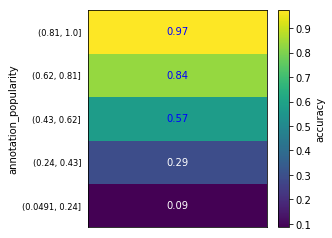

In [17]:
## Example: Fairness through the angle of the annotations and their accuracy.
# Choose "accuracy" as the target metric. 
# Choose "annotation_popularity" as the fairness angle to investigate.
# Choose "characterization = True" to visualize the fairness elements.
target_metric = ('accuracy',)
fairness_angle = 'annotation_popularity'
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', fairness_angle, target_metric, characterization=True, image_folder='fig_test1')
print("Fairness computed over ", target_metric[0], " through the ", fairness_angle, ":")
print("- Fairness value: ", metric_result[target_metric[0]][0])
print("- General performance: ", metric_result[target_metric[0]][1])

TODO: check whether bins are in order


..\aif360\metrics\inclusiveness_label_dataset_metric.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = data.as_matrix(columns=[metric])
c:\users\agathebalayn\documents\thesis_related\virtualenvs\aif306_v2\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


{'accuracy': (0.6705708667175279, 0.5516486828837598), 'F1': (0.7433784785375308, 0.2934419615539497), 'TPR': (0.7563239193651281, 0.22989183558941545), 'TNR': (0.8561732482464234, 0.8659134002823261), 'FPR': (0.8561732482464234, 0.13408659971767387), 'FNR': (0.7563239193651281, 0.7701081644105845)}                 level_0   index       rev_id  worker_id  label  label_score  \
bin_col                                                                       
(0.0491, 0.24]   205309  249229   75210105.0       1922      1         -1.0   
(0.24, 0.43]     120642  146566   49256374.0       1986      1         -2.0   
(0.43, 0.62]     151061  183464   58867483.0       2140      0          0.0   
(0.62, 0.81]     271057  329045  101181854.0       1026      0          1.0   
(0.81, 1.0]      269797  327507  100561070.0       2427      0          0.0   

                gender  english_first_language age_group     education  \
bin_col                                                                

..\aif360\metrics\inclusiveness_label_dataset_metric.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  matrix_data = data.as_matrix([metric])


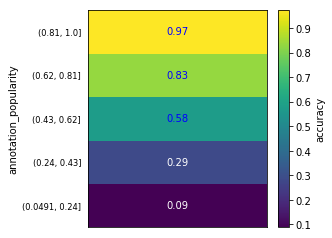

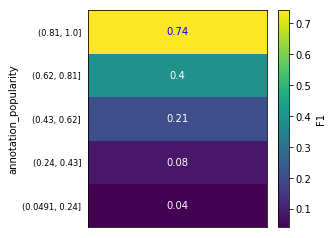

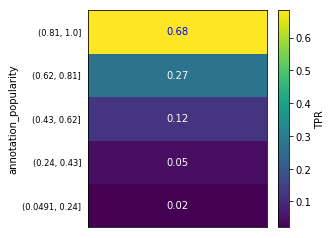

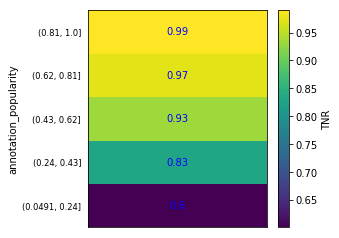

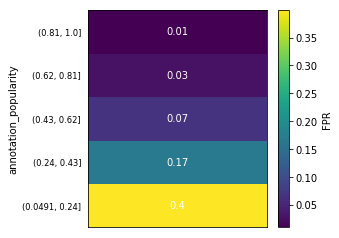

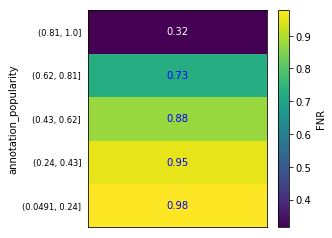

In [18]:
# Fairness through the angle of the annotations and their accuracy, F-measure and other rates. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'annotation_popularity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)

In [ ]:
# Fairness through the angle of the user demographics and several performance measures. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'demography', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)

In [ ]:
# Fairness through the angle of the samples and several performance measures.  
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'sample_ambiguity', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'))
print(metric_result, data_metric)

In [ ]:
# Fairness through the angle of the users and several performance measures. 
metric_result, data_metric = metrics_inclusiveness_test.compute_metric(prediction_col, 'label', 'annotator_disagreement', ('accuracy', 'F1', 'TPR', 'TNR', 'FPR', 'FNR'), characterization=True)
print(metric_result, data_metric)